<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/information_retrieval/IR_H_M_2025_Exercise2_TEMPLATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval Exercise 2 Notebook


This is the template notebook for Exercise 2. The specification for the exercise and the corresponding Exercise 2 Quiz submission instance are available on the Moodle page of the course.

This exercise builds upon Exercise 1, and assumes that you are now familiar with concepts we have introduced in both the Lab 1 and Exercise 1, including:
 - [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - [Pyterrier apply transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 - [PyTerrier pt.Experiment()](https://pyterrier.readthedocs.io/en/latest/experiments.html)


## PyTerrier Setup

First, let's install PyTerrier as usual. We require a specific version of LightGBM. Do not change this version - if you are running locally on Apple Silicon, this wont work, and you should move back to Google Colab.

In [2]:
%pip install -q python-terrier lightgbm==2.2.3 pyterrier-caching

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.6 MB/s eta 0:00:00


Let's start PyTerrier

In [3]:
import pyterrier as pt

# we require a specific version of LightGBM for this exercise
import lightgbm
assert lightgbm.__version__ == '2.2.3'

We're going to speed things up for you by caching the PL2 results and the standard feature set.

DO NOT be tempted to cache your own feature implementations.

In [4]:
from pyterrier_caching import RetrieverCache, SparseScorerCache

CACHE=True

## Index, Topics & Qrels for Exercise 2

You will need your login & password credentials from Exercise 1. We will be using again the "50pct" and the "trec-wt-2004" datasets from Exercise 1.


In [5]:
UNAME="3043532a"
PWORD="e6adaf2c"

# we will again be using the "50pct" and "trec-wt-2004" datasets
Fiftypct = pt.get_dataset("50pct",  user=UNAME, password=PWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

On the other hand, you will be using a slightly updated index for Exercise 2. It is a bit bigger than the Exercise 1 index, hence it takes about 2-3 minutes to download to Colab.


In [6]:

indexref = Fiftypct.get_index(variant="ex3")
index = pt.IndexFactory.of(indexref, memory=True)


data.meta-0.fsomapfile:   0%|          | 0.00/50.1M [00:00<?, ?iB/s]

data-pagerank.oos:   0%|          | 0.00/9.52M [00:00<?, ?iB/s]

data.direct.bf: 0.00iB [00:00, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/19.3M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/384M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/183M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/7.80M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/6.16M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/861M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/3.74k [00:00<?, ?iB/s]

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by IndexFactory.of) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


Let's check out the new index. Compared to the index we used for Exercise 1, you can see that this index has `Field Names: [TITLE, ELSE]`, which means that we can provide statistics about how many times each term occurs in the title of each document (the "TITLE" field), vs the rest of the document (the "ELSE" field). Refer to Lecture 7 for more information about fields.

Let's also display the keys in the meta index - this is the metadata that we have stored for each document. You can see that we are storing the "url" and the "body" (content) of the document. These will particularly come in handy for Q2 and Q3 of Exercise 2, respectively.


In [7]:
print(index.getCollectionStatistics())
print("In the meta index: " + str(index.getMetaIndex().getKeys()))

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 2
Number of tokens: 572916194
Field names: [TITLE, ELSE]
Positions:   false

In the meta index: ['docno', 'url', 'title', 'body']


Finally, these are all of the topics and qrels (including the training and validation datasets) that you will need to conduct Exercise 2.

In [8]:
tr_topics = Fiftypct.get_topics("training")
va_topics = Fiftypct.get_topics("validation")

tr_qrels = Fiftypct.get_qrels("training")
va_qrels = Fiftypct.get_qrels("validation")

test_topics = dotgov_topicsqrels.get_topics("hp")
test_qrels = dotgov_topicsqrels.get_qrels("hp")

training.topics:   0%|          | 0.00/7.75k [00:00<?, ?iB/s]

validation.topics:   0%|          | 0.00/4.39k [00:00<?, ?iB/s]

training.qrels:   0%|          | 0.00/2.88k [00:00<?, ?iB/s]

validation.qrels:   0%|          | 0.00/1.48k [00:00<?, ?iB/s]

Web2004.query.stream.trecformat.txt:   0%|          | 0.00/15.3k [00:00<?, ?iB/s]

04.topic-map.official.txt:   0%|          | 0.00/2.53k [00:00<?, ?iB/s]

04.qrels.web.mixed.txt:   0%|          | 0.00/1.90M [00:00<?, ?iB/s]

## Baseline Setup

We introduce here the terrier.Retriever for our baseline. Note that:
 - We are using PL2 as our weighting model to generate the candidate set of documents to re-rank.
 - We expose more document metadata, namely "url" and "body" for each document retrieved, which you will need to deploy your two new features.
 - By setting `verbose=True`, we display a progress bar while retrieval executes.
 - We cache PL2 to make it faster for reuse in later experiments.

In [9]:
firstpass = pt.terrier.Retriever(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
if CACHE: # wrap in a cache transformer
    firstpass = RetrieverCache('pl2-cache', firstpass)

Let's see the resulting output - you can see that there are now "url" and "body" attributes for each retrieved document. (We also display a progress bar, enabled by the `verbose=True`).

In [10]:
firstpass.search("chemical reactions")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

BitPostingIndex loading /root/.pyterrier/corpora/50pct/index/ex3/data.inverted.bf to memory


,qid,docid,docno,url,body,rank,score,query
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. \r\n \r\n \r\n \...,1,11.906524,chemical reactions
2,1,707122,G26-06-3754605,http://www.aps.anl.gov/xfd/tech/safetyenvelope...,APS Experiment Safety Envelope 6: Chemicals \r...,2,11.877550,chemical reactions
3,1,382754,G13-59-3981168,http://response.restoration.noaa.gov/chemaids/...,"""); }\n else {\n document.wr...",3,11.858475,chemical reactions
4,1,70292,G02-16-2617043,http://www.symp14.nist.gov/PDF/COR04MAY.PDF,A Database of Chemical Reactions Designed to A...,4,11.731490,chemical reactions
...,...,...,...,...,...,...,...,...
995,1,246965,G08-68-4141101,http://en-env.llnl.gov/asd/pinatub.html,The Chemical and Radiative Effects of the Moun...,995,6.290707,chemical reactions
996,1,611136,G22-04-3955177,http://eospso.gsfc.nasa.gov/ftp_docs/Ch7.pdf,Chapter 7\n ...,996,6.289822,chemical reactions
997,1,594957,G21-38-0191596,http://www.oit.doe.gov/news/oittimes/wn02/wn02...,search \r\n\t\t\t\t\t\t\t\t \r\n\t\t\t\t\t\t\...,997,6.287830,chemical reactions
998,1,280944,G09-85-3411646,http://www.ig.doe.gov/pdf/chemfina.pdf,INS-O-00-01\n\n\n\n\n\n\n\n\n I N S P E C T...,998,6.287759,chemical reactions


# Standard List of Features

Let's introduce the list of features we need to deploy a baseline learning-to-rank approach.

We again cache the results of FeaturesRetriever to make it faster.

In [11]:
pagerankfile = indexref + "/data-pagerank.oos"

# DO *NOT* CHANGE THIS LIST. Use PyTerrier operators to add features...
features = [
    "SAMPLE", #ie PL2 - this exposes the scores used to obtain the candidate set as a feature
    "WMODEL:SingleFieldModel(BM25,0)", #BM25 title
    "QI:StaticFeature(OIS,%s)" % pagerankfile,
]

stdfeatures = pt.terrier.FeaturesRetriever(index, features, verbose=True)
if CACHE: # wrap in a cache transformer
    stdfeatures = SparseScorerCache('features-cache', stdfeatures, value="features", pickle=True, verbose=True)

stage12 = firstpass >> stdfeatures

This is our feature set. We will be using FeaturesBatchRetrieve to compute these extra features on the fly. Let's see the output. You can see that there is now a "features" column.

In [12]:
stage12.search("chemical reactions").head(2)

TerrierFeatRetr(3 features):   0%|          | 0/1 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

,qid,docid,docno,url,body,rank,score,query,features
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions,"[12.755545561073266, 3.0924078763629836, 0.000..."
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. \r\n \r\n \r\n \...,1,11.906524,chemical reactions,"[11.90652405775751, 10.789390732195702, 0.0002..."


Let's look in more detail at the features. It is clear that there are 3 numbers for each document. The first is the PL2 score (1.27555456e+01 == 12.7555), the second is the BM25 score, and the third is the PageRank (a link analysis feature - discussed in more detail in Lecture 9)

In [13]:
stage12.search("chemical reactions").head(1).iloc[0]["features"]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

array([1.27555456e+01, 3.09240788e+00, 1.05668333e-04])

# Q1

You now have everyting you need to attempt Q1. You will need to refer to the specification, and to PyTerrier's [learning to rank documentation](https://pyterrier.readthedocs.io/en/latest/ltr.html).

You should use a LightGBM LambdaMART implementation (*not* XGBoost), instantiated using the configuration suggested in the PyTerrier documentation.

Hints:
 - You will need to use the provided separate “training” and “validation” topic sets and qrels to train the learning-to-rank.
 - There is no need to vary the configuration of LightGBM from that in the documentation.
 - Training and evaluating a LTR pipeline takes around 5 minutes.

In [14]:
#YOUR SOLUTION
import lightgbm as lgb
from scipy.stats import ttest_rel

lmart_l = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

lmart_l_pipe = stage12 >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
lmart_l_pipe.fit(tr_topics, tr_qrels, va_topics, va_qrels)

# Evaluate PL2 baseline with per-query results
pl2_results = pt.Experiment(
    [firstpass],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2"],
    perquery=True
)

# Evaluate LTR with per-query results
ltr_results = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["LTR"],
    perquery=True
)

# Debug: Print DataFrames (optional, for confirmation)
print("PL2 Results DataFrame:")
print(pl2_results)
print("LTR Results DataFrame:")
print(ltr_results)

# Aggregate results for display
pl2_agg = pl2_results.groupby(["name", "measure"])["value"].mean().unstack()
ltr_agg = ltr_results.groupby(["name", "measure"])["value"].mean().unstack()

print("PL2 Baseline Results (Aggregated):")
print(pl2_agg)
print("LTR Results (Aggregated):")
print(ltr_agg)

# Extract per-query scores for t-test
# Filter for 'map' and 'P_5' separately, ensuring qid alignment
pl2_map_df = pl2_results[pl2_results["measure"] == "map"][["qid", "value"]].sort_values("qid")
ltr_map_df = ltr_results[ltr_results["measure"] == "map"][["qid", "value"]].sort_values("qid")
pl2_p5_df = pl2_results[pl2_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")
ltr_p5_df = ltr_results[ltr_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")

# Verify qids match between PL2 and LTR
if not (pl2_map_df["qid"].equals(ltr_map_df["qid"]) and pl2_p5_df["qid"].equals(ltr_p5_df["qid"])):
    raise ValueError("Query IDs (qid) do not match between PL2 and LTR results")

# Extract score arrays
pl2_map_scores = pl2_map_df["value"].values
ltr_map_scores = ltr_map_df["value"].values
pl2_p5_scores = pl2_p5_df["value"].values
ltr_p5_scores = ltr_p5_df["value"].values

# Conduct t-tests
map_ttest = ttest_rel(ltr_map_scores, pl2_map_scores)
p5_ttest = ttest_rel(ltr_p5_scores, pl2_p5_scores)

print(f"MAP t-test: p-value = {map_ttest.pvalue:.4f}")
print(f"P@5 t-test: p-value = {p5_ttest.pvalue:.4f}")

# Conclusion
if map_ttest.pvalue < 0.05:
    print("LTR is significantly better than PL2 in terms of MAP.")
else:
    print("LTR is not significantly better than PL2 in terms of MAP.")

if p5_ttest.pvalue < 0.05:
    print("LTR is significantly better than PL2 in terms of P@5.")
else:
    print("LTR is not significantly better than PL2 in terms of P@5.")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

TerrierFeatRetr(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

TerrierFeatRetr(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.148148
[2]	valid_0's ndcg@1: 0.203704
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.37037
[6]	valid_0's ndcg@1: 0.37037
[7]	valid_0's ndcg@1: 0.388889
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926


TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

TerrierFeatRetr(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


PL2 Results DataFrame:
   name  qid measure     value
62  PL2  106     map  0.058824
63  PL2  106     P_5  0.000000
64  PL2  108     map  1.000000
65  PL2  108     P_5  0.200000
66  PL2  109     map  0.023256
..  ...  ...     ...       ...
57  PL2   94     P_5  0.000000
58  PL2   95     map  0.015873
59  PL2   95     P_5  0.000000
60  PL2   98     map  0.006803
61  PL2   98     P_5  0.000000

[150 rows x 4 columns]
LTR Results DataFrame:
   name  qid measure     value
62  LTR  106     map  1.000000
63  LTR  106     P_5  0.200000
64  LTR  108     map  0.015385
65  LTR  108     P_5  0.000000
66  LTR  109     map  0.100000
..  ...  ...     ...       ...
57  LTR   94     P_5  0.000000
58  LTR   95     map  0.007692
59  LTR   95     P_5  0.000000
60  LTR   98     map  0.250000
61  LTR   98     P_5  0.200000

[150 rows x 4 columns]
PL2 Baseline Results (Aggregated):
measure       P_5      map
name                      
PL2      0.069333  0.22511
LTR Results (Aggregated):
measure       P_5   

# Q2 - URL Length Features

In this block, please provide your code for Q2 concerning your two URL Length features, namely URL Length by counting slashes (URL-slashes) and URL Length through using the type of the URL (URL-type). The two different URL length features that you will need to implement are detailed in the specification. Do carefully read and follow the Exercise 2 specification before starting the implementation of the features.

Some hints:

 - For computing each of your URL features, you will need to use an appropriate [pt.apply function](https://pyterrier.readthedocs.io/en/latest/apply.html). The dataframe of results obtained from the `firstpass` transformer has all of the information you need. You can see how fast your apply function is by setting `verbose=True`.

 - You can use the `**` PyTerrier operator for combining feature sets.

 - Refer to the PyTerrier learning to rank documentation  concerning `feature_importances_` for obtaining feature importances.

 - You may wish to refer to Python's [`urlparse()`](https://docs.python.org/3/library/urllib.parse.html) function.

 - Use Python assertions to test that your feature implmentation(s) give the expected results. **Remember that you need to report along your code all the tests you have conducted to ascertain the code's correctness.**


## Q2 (a) URL-Slashes Feature

In this block you should define your URL-Slashes feature, and **test it**. **Show clearly all the tests** that you have conducted to test that your feature works as expected.

In [15]:
from urllib.parse import urlparse

def url_slashes_count(url):
  parsed = urlparse(url)
  path = parsed.path  # Extract path from URL
  return path.rstrip('/').count('/')

# Tests for URL-Slashes
assert url_slashes_count("http://example.com") == 0, "Basic URL test failed"
assert url_slashes_count("http://example.com/path/to/page") == 3, "Multi-path test failed"
assert url_slashes_count("http://example.com/") == 0, "Trailing slash test failed"
assert url_slashes_count("ftp://user@host:port/path") == 1, "Non-http protocol test failed"
assert url_slashes_count("http://trec.nist.gov") == 0, "Root without slash test failed"
assert url_slashes_count("http://trec.nist.gov/index.html") == 1, "Root with index.html test failed"
assert url_slashes_count("http://trec.nist.gov/pubs/") == 1, "Subroot test failed"
assert url_slashes_count("http://trec.nist.gov/pubs/index.html") == 2, "Subroot with index.html test failed"
assert url_slashes_count("http://trec.nist.gov/pubs/trec9/papers/") == 3, "Deep path test failed"
assert url_slashes_count("http://trec.nist.gov/pubs/trec9/t9_proceedings.html") == 3, "File in deep path test failed"

print("All URL-Slashes tests passed")

All URL-Slashes tests passed


#### (i) URL-Slashes as a PL2 re-ranker

Now you should evaluate your URL-slashes score by re-ranking PL2, without applying learning-to-rank.

Hint:
 - Your reranker should order documents in descending order, i.e. longest URLs first.

 You can now answer the corresponding quiz questions.

In [16]:
# PyTerrier Transformer for URL slashes count feature
URLSlashFeature = pt.apply.url(lambda row: url_slashes_count(row['url']), verbose=True)

# Apply URL slash feature and re-rank based on PL2 first, then slashes
url_slash_reranker = URLSlashFeature >> pt.apply.generic(
    lambda df: df.sort_values('url', ascending=False)
)
pipeline = firstpass >> url_slash_reranker

# Run evaluation
eval_results = pt.Experiment(
    [firstpass, pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2 Baseline", "URL-Slashes Reranker"]
)

# Print results rounded to 5 decimal places for accuracy
print(eval_results.round(5))

                   name      map      P_5
0          PL2 Baseline  0.22511  0.06933
1  URL-Slashes Reranker  0.22511  0.06933


In [17]:
query = pt.new.queries(["cryption"], qid=["1"])
results = pipeline.transform(query)
top_docno = results.iloc[0]["docno"]

print(f"Top-ranked document Docno for query 'cryption': {top_docno}")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

Top-ranked document Docno for query 'cryption': G17-68-2584616


#### (ii) URL-Slashes within an LTR model

Now you should evaluate your URL-slashes score as a feature within a new learned model.

Hint:
 - Carefully consider how to integrate your feature into an LTR model, based on your understanding of how a regression tree works.

You can now answer the corresponding quiz questions.

In [18]:
# YOUR SOLUTION
# URL slash pipeline
slashes_pipeline = firstpass >> (URLSlashFeature ** stdfeatures)

# Define the LTR model
ltr_slashes = lgb.LGBMRanker(
    objective="lambdarank",
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    metric="map",
    verbose=-1
)

# Create and fit the LTR pipeline
ltr_slashes_pipeline = slashes_pipeline >> pt.ltr.apply_learned_model(ltr_slashes, form="ltr")
ltr_slashes_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

# Evaluate the results
slashes_ltr_results = pt.Experiment(
    [firstpass, lmart_l_pipe, ltr_slashes_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2 Baseline", "LTR Baseline", "LTR+URL Slash count feature"]
)


print(slashes_ltr_results)
print("Feature Importance: ", ltr_slashes.feature_importances_)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's map@1: 0.240741
[2]	valid_0's map@1: 0.314815
[3]	valid_0's map@1: 0.314815
[4]	valid_0's map@1: 0.425926
[5]	valid_0's map@1: 0.425926
[6]	valid_0's map@1: 0.444444
[7]	valid_0's map@1: 0.518519
[8]	valid_0's map@1: 0.518519
[9]	valid_0's map@1: 0.537037
[10]	valid_0's map@1: 0.537037
[11]	valid_0's map@1: 0.537037
[12]	valid_0's map@1: 0.537037
[13]	valid_0's map@1: 0.481481
[14]	valid_0's map@1: 0.481481
[15]	valid_0's map@1: 0.462963
[16]	valid_0's map@1: 0.462963
[17]	valid_0's map@1: 0.462963
[18]	valid_0's map@1: 0.462963
[19]	valid_0's map@1: 0.444444
[20]	valid_0's map@1: 0.444444
[21]	valid_0's map@1: 0.444444
[22]	valid_0's map@1: 0.444444
[23]	valid_0's map@1: 0.425926
[24]	valid_0's map@1: 0.425926
[25]	valid_0's map@1: 0.425926
[26]	valid_0's map@1: 0.425926
[27]	valid_0's map@1: 0.444444
[28]	valid_0's map@1: 0.425926
[29]	valid_0's map@1: 0.407407
[30]	valid_0's map@1: 0.407407
[31]	valid_0's map@1: 0.388889
[32]	valid_0's map@1: 0.37037
[33]	valid_0's map

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                          name       map       P_5
0                 PL2 Baseline  0.225110  0.069333
1                 LTR Baseline  0.357864  0.101333
2  LTR+URL Slash count feature  0.357374  0.098667
Feature Importance:  [5014    0 4348 5638]


In [19]:
eval_results = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map"],
    names=["LTR with URL-Slashes"],
    perquery=True
)

merged = ltr_results[ltr_results["measure"] == "map"].merge(
    eval_results[eval_results["measure"] == "map"],
    on="qid",
    suffixes=("_3", "_4")
)

merged["ap_diff"] = merged["value_4"] - merged["value_3"]

improved_queries = len(merged[merged["ap_diff"] > 0])
not_improved_queries = len(merged[merged["ap_diff"] <= 0])

print(f"Number of queries improved by 4-feature LTR over 3-feature LTR: {improved_queries}")
print(f"Number of queries not improved by 4-feature LTR over 3-feature LTR: {not_improved_queries}")

# Optional: Print total queries for verification
total_queries = len(merged)
print(f"Total queries evaluated: {total_queries}")

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of queries improved by 4-feature LTR over 3-feature LTR: 0
Number of queries not improved by 4-feature LTR over 3-feature LTR: 75
Total queries evaluated: 75


In [20]:
from scipy.stats import ttest_rel
import numpy as np

# Per-query results for 4-feature LTR
eval_results = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["LTR with URL-Slashes"],
    perquery=True
)

# Filter and sort
ltr_map_df = ltr_results[ltr_results["measure"] == "map"][["qid", "value"]].sort_values("qid")
eval_map_df = eval_results[eval_results["measure"] == "map"][["qid", "value"]].sort_values("qid")
ltr_p5_df = ltr_results[ltr_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")
eval_p5_df = eval_results[eval_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")

# Verify qids
if not (ltr_map_df["qid"].equals(eval_map_df["qid"]) and ltr_p5_df["qid"].equals(eval_p5_df["qid"])):
    raise ValueError("Query IDs do not match")

# Extract scores
ltr_map_scores = ltr_map_df["value"].values
eval_map_scores = eval_map_df["value"].values
ltr_p5_scores = ltr_p5_df["value"].values
eval_p5_scores = eval_p5_df["value"].values

# Compute differences
map_diff = eval_map_scores - ltr_map_scores
p5_diff = eval_p5_scores - ltr_p5_scores

# Handle zero variance
map_pvalue = 1.0 if np.std(map_diff) == 0 else ttest_rel(eval_map_scores, ltr_map_scores).pvalue
p5_pvalue = 1.0 if np.std(p5_diff) == 0 else ttest_rel(eval_p5_scores, ltr_p5_scores).pvalue

print(f"MAP t-test p-value: {map_pvalue}")
print(f"P@5 t-test p-value: {p5_pvalue}")

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MAP t-test p-value: 1.0
P@5 t-test p-value: 1.0


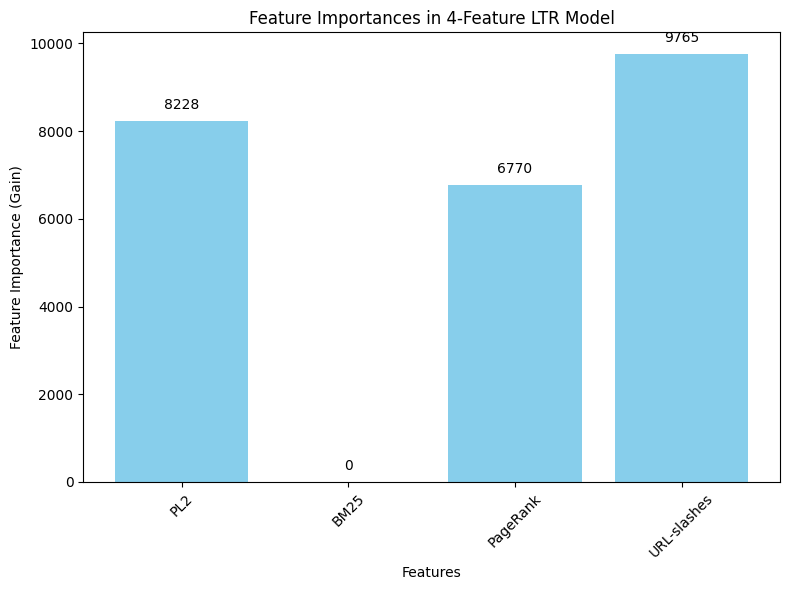

In [21]:
import matplotlib.pyplot as plt

features = ["PL2", "BM25", "PageRank", "URL-slashes"]
importances = [8228, 0, 6770, 9765]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(features, importances, color="skyblue")
plt.xlabel("Features")
plt.ylabel("Feature Importance (Gain)")
plt.title("Feature Importances in 4-Feature LTR Model")
plt.xticks(rotation=45)

# Add importance values on top of bars
for i, v in enumerate(importances):
    plt.text(i, v + 200, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

## Q2 (b) URL Type Feature

In this block you should define your URL Type feature and **test it**. **Show clearly all the tests** you have conducted to test that your feature works as expected.

In [22]:
from urllib.parse import urlparse

def url_category(url):
    url = url.rstrip('/')
    parsed = urlparse(url)
    path = parsed.path
    # print(path)
    if path == "" or path == "/index.html":  # Root (0)
        return 0
    elif path.count('/') == 1 and (not path.endswith('index.html') or path == "/index.html"):  # Subroot (1)
        return 1
    elif path.count('/') > 1 and path.endswith('/index.html'):  # Path (2)
        return 2
    else:  # File (3)
        return 3

# Test cases with comprehensive validation
test_cases = [
    ("http://example.com", 0, "Root category test failed"),
    ("http://example.com/", 0, "Root category with trailing slash test failed"),
    ("http://example.com/index.html", 0, "Root category with index.html test failed"),
    ("http://example.com/pubs/", 1, "Subroot category test failed"),
    ("http://example.com/pubs/index.html", 2, "Subroot category with index.html test failed"),
    ("http://example.com/pubs/trec9/papers/file.html", 3, "File category test failed"),
    ("http://example.com/pubs/trec9/papers/otherfile.htm", 3, "File category with other file extension test failed"),
    ("http://example.com/pubs/trec9/index.html", 2, "Path category with index.html test failed"),
]

# Running tests
for url, expected, message in test_cases:
    result = url_category(url)
    assert result == expected, f"{message}: Expected {expected}, got {result}"
    print(f"Passed: {url} -> {result}")


Passed: http://example.com -> 0
Passed: http://example.com/ -> 0
Passed: http://example.com/index.html -> 0
Passed: http://example.com/pubs/ -> 1
Passed: http://example.com/pubs/index.html -> 2
Passed: http://example.com/pubs/trec9/papers/file.html -> 3
Passed: http://example.com/pubs/trec9/papers/otherfile.htm -> 3
Passed: http://example.com/pubs/trec9/index.html -> 2


#### (i) URL Type as a PL2 re-ranker

Now you should evaluate your URL type score by re-ranking PL2, without applying learning-to-rank.

Hint:
 - Your reranker should order documents in descending order, i.e. longest URLs first.

You can now answer the corresponding quiz questions.

In [23]:
#YOUR SOLUTION
# PyTerrier Transformer to Apply URL Categorization
class URLCategoryFeature(pt.Transformer):
    def transform(self, df):
        df["url_category"] = df["url"].apply(url_category)
        return df

url_category_reranker = URLCategoryFeature() >> pt.apply.generic(
    lambda df: df.sort_values(["score", "url_category"], ascending=[False, True])  # Lower category value = Higher Rank
)

pipeline_category = firstpass >> url_category_reranker

eval_results = pt.Experiment(
    [firstpass, pipeline_category],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2 Baseline", "PL2 + URL Category Reranker"]
)

# Print results rounded to 5 decimal places
print(eval_results.round(5))

                          name      map      P_5
0                 PL2 Baseline  0.22511  0.06933
1  PL2 + URL Category Reranker  0.22511  0.06933


In [24]:
query = pt.new.queries(["aaie"], qid=["1"])
results = pipeline_category.transform(query)
top_docno = results.iloc[0]["docno"]

print(f"Top-ranked document Docno for query 'cryption': {top_docno}")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

Top-ranked document Docno for query 'cryption': G19-52-0995113


#### (ii) URL Type within an LTR model

Now you should evaluate your URL type score as a feature within a new learned model.

Hint:
 - Carefully consider how to integrate your feature into an LTR model, based on your understanding of how a regression tree works.

You can now answer the corresponding quiz questions.

In [25]:
url_type_feature = pt.apply.url(lambda row: url_category(row['url']), verbose=True)

# Define the feature pipeline
type_feature_pipeline = firstpass >> (url_type_feature ** stdfeatures)

ltr_type = lgb.LGBMRanker(
    objective="lambdarank",
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    metric="map",
    verbose=-1
)

# Create and fit the LTR pipeline
ltr_type_pipeline = type_feature_pipeline >> pt.ltr.apply_learned_model(ltr_type, form="ltr")
ltr_type_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

# Evaluate the results
type_ltr_results = pt.Experiment(
    [firstpass, lmart_l_pipe, ltr_type_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2 Baseline", "LTR Baseline", "LTR+URL-Type"]
)

# Print results and feature importances
print("URL-Type LTR Results:")
print(type_ltr_results)
# Corrected: Use ltr_type instead of ltr_type_pipeline
print("Feature Importances:", ltr_type.feature_importances_)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's map@1: 0.240741
[2]	valid_0's map@1: 0.314815
[3]	valid_0's map@1: 0.314815
[4]	valid_0's map@1: 0.425926
[5]	valid_0's map@1: 0.425926
[6]	valid_0's map@1: 0.444444
[7]	valid_0's map@1: 0.518519
[8]	valid_0's map@1: 0.518519
[9]	valid_0's map@1: 0.537037
[10]	valid_0's map@1: 0.537037
[11]	valid_0's map@1: 0.537037
[12]	valid_0's map@1: 0.537037
[13]	valid_0's map@1: 0.481481
[14]	valid_0's map@1: 0.481481
[15]	valid_0's map@1: 0.462963
[16]	valid_0's map@1: 0.462963
[17]	valid_0's map@1: 0.462963
[18]	valid_0's map@1: 0.462963
[19]	valid_0's map@1: 0.444444
[20]	valid_0's map@1: 0.444444
[21]	valid_0's map@1: 0.444444
[22]	valid_0's map@1: 0.444444
[23]	valid_0's map@1: 0.425926
[24]	valid_0's map@1: 0.425926
[25]	valid_0's map@1: 0.425926
[26]	valid_0's map@1: 0.425926
[27]	valid_0's map@1: 0.444444
[28]	valid_0's map@1: 0.425926
[29]	valid_0's map@1: 0.407407
[30]	valid_0's map@1: 0.407407
[31]	valid_0's map@1: 0.388889
[32]	valid_0's map@1: 0.37037
[33]	valid_0's map

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


URL-Type LTR Results:
           name       map       P_5
0  PL2 Baseline  0.225110  0.069333
1  LTR Baseline  0.357864  0.101333
2  LTR+URL-Type  0.357374  0.098667
Feature Importances: [5014    0 4348 5638]


In [40]:
ltr_results = pt.Experiment(
    [ltr_type_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["P_5"],
    names=["LTR+URL-Type"],
    perquery=True
)

eval_results = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["P_5"],
    names=["LTR"],
    perquery=True
)

merged = ltr_results[ltr_results["measure"] == "map"].merge(
    eval_results[eval_results["measure"] == "map"],
    on="qid",
    suffixes=("_3", "_4")
)

merged["ap_diff"] = merged["value_4"] - merged["value_3"]

improved_queries = len(merged[merged["ap_diff"] > 0])
not_improved_queries = len(merged[merged["ap_diff"] <= 0])

print(f"Number of queries improved by 4-feature LTR over 3-feature LTR: {improved_queries}")
print(f"Number of queries not improved by 4-feature LTR over 3-feature LTR: {not_improved_queries}")

# Optional: Print total queries for verification
total_queries = len(merged)
print(f"Total queries evaluated: {total_queries}")

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of queries improved by 4-feature LTR over 3-feature LTR: 32
Number of queries not improved by 4-feature LTR over 3-feature LTR: 43
Total queries evaluated: 75


In [43]:
from scipy.stats import ttest_rel
import pandas as pd
ltr_results = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["LTR"],
    perquery=True
)
ltr_url_results = pt.Experiment(
    [ltr_type_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["LTR+URL-Type"],
    perquery=True
)
# Extract per-query MAP scores
baseline_map_scores = ltr_results[ltr_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")
url_type_map_scores = ltr_url_results[ltr_url_results["measure"] == "P_5"][["qid", "value"]].sort_values("qid")

# Extract MAP score arrays
baseline_values = baseline_map_scores["value"].values
url_type_values = url_type_map_scores["value"].values

# Conduct paired t-test
map_ttest = ttest_rel(url_type_values, baseline_values)

# Print the p-value
print(f"p-value for MAP t-test: {map_ttest.pvalue:.4f}")


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


p-value for MAP t-test: 0.8203


# Q3 Proximity Search Feature

Now you will implement a new query-dependent feature, using the MinDist() function, as discussed in the specification. Do carefully **read the Exercise 2 specification** before starting the implementation.

Hints:
 - Again, remember to use assertions to **test** your feature implementations.
 - Refer to the PyTerrier learning to rank documentation concerning `features_importances_` for obtaining feature importances
 - For tokenisation of queries and documents, you can simply use Python's [`str.split()`](https://docs.python.org/3.3/library/stdtypes.html#str.split), without any arguments. Do not use any external libraries.

As mentioned in the specification, you should implement a function called `avgmindist()`, which takes the text of the query and the text of the document, and returns a score for the document, i.e. it must conform to the following Python specification:
```python
def avgmindist(query : str, document : str) -> float
```

**NB**: There are particular specific requirements for your implementations of MinDist() and avgmindist() that are detailed in the specification.

In [28]:
#YOUR AVGMINDIST IMPLEMENTATION

def avgmindist(query : str, document : str) -> float:
  #update your implementation here.
    query_tokens = query.split()
    doc_tokens = document.split()
    if len(query_tokens) < 2 or not doc_tokens:
        return float('inf')
    total_dist, pair_count = 0, 0
    for i in range(len(query_tokens)):
        for j in range(i + 1, len(query_tokens)):
            pos1 = [idx for idx, t in enumerate(doc_tokens) if t == query_tokens[i]]
            pos2 = [idx for idx, t in enumerate(doc_tokens) if t == query_tokens[j]]
            if pos1 and pos2:
                min_dist = min(abs(p1 - p2) for p1 in pos1 for p2 in pos2)
                total_dist += min_dist
                pair_count += 1
    return total_dist / pair_count if pair_count > 0 else float('inf')

You should test your impementation yourself (your code must list along your code *all* the test cases you deployed to test that your feature works as expected). In addition, to also allow us to verify your implementation, we have created 9 testcases. Please run `run_test_cases()` and use its responses to answer the relevant quiz questions.

Hint:
 - Our test cases took around 1-3ms each. If the testing of your implementation takes magnitudes of time longer, then this will impact upon how long it takes you to train and evaluate your implementation within a LTR pipeline.


In [29]:
#DO NOT ALTER THIS CELL
TEST_CASES = [
  ('fermilab directory', 45, 567257), #1
  ('webcam', 45, 567257), #2
  ('DOM surface', 384034, 388292), #3
  ('DOM surface', 45, 384034), #4
  ('DOM surface document', 388292, 384034), #5
  ('DOM software AMANDA', 639302, 384034), #6
  ('fermilab directory', 388292, 384034), #7
  ('trigger data', 596532, 639302), #8
  ('underlying hardware', 384034, 333649) #9
]

def run_test_cases():
  import datetime
  docno=0
  body=3
  for i, (query, docid1, docid2) in enumerate(TEST_CASES):
    start = datetime.datetime.now()
    meta1 = index.getMetaIndex().getAllItems(docid1)
    meta2 = index.getMetaIndex().getAllItems(docid2)
    s1 = avgmindist(query, meta1[body])
    s2 = avgmindist(query, meta2[body])
    if s1 > s2:
      result = meta1[docno]
      cmpD = "%s > %s" % (meta1[docno],meta2[docno])
    elif s2 > s1:
      result = meta2[docno]
      cmpD = "%s > %s" % (meta2[docno],meta1[docno])
    else:
      result = "EQUAL"
      cmpD = "%s == %s" % (meta1[docno],meta2[docno])
    end = datetime.datetime.now()
    print("TEST CASE %d result %s time %d ms" % (i+1, result, float((end-start).microseconds)/1000.))

run_test_cases()

TEST CASE 1 result EQUAL time 1 ms
TEST CASE 2 result EQUAL time 1 ms
TEST CASE 3 result G13-64-2457111 time 0 ms
TEST CASE 4 result EQUAL time 0 ms
TEST CASE 5 result G13-80-1271020 time 1 ms
TEST CASE 6 result G13-64-2457111 time 0 ms
TEST CASE 7 result EQUAL time 0 ms
TEST CASE 8 result G23-17-3674898 time 0 ms
TEST CASE 9 result G13-64-2457111 time 0 ms


You should now integrate your avgmindist() function into a new LTR model, and compare its MAP & P@5 performance to the LTR baseline. You can now answer the corresponding quiz questions.

In [30]:
#YOUR SOLUTION
import numpy as np
proximity_feature = pt.apply.features(
    lambda row: np.append(row['features'], avgmindist(str(row['query']), str(row['body']))),
    verbose=True
)
proximity_feature_pipeline = firstpass >> stdfeatures >> proximity_feature

ltr_proximity = lgb.LGBMRanker(
    objective="lambdarank",
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    metric="map",
    verbose=-1
)

ltr_proximity_pipeline = proximity_feature_pipeline >> pt.ltr.apply_learned_model(ltr_proximity, form="ltr")
ltr_proximity_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

proximity_results = pt.Experiment(
    [firstpass, lmart_l_pipe, ltr_proximity_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["PL2 Baseline", "LTR Baseline", "LTR+Proximity"]
)
print("Proximity LTR Results:")
print(proximity_results)
print("Feature Importances:", ltr_proximity.feature_importances_)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's map@1: 0.259259
[2]	valid_0's map@1: 0.351852
[3]	valid_0's map@1: 0.388889
[4]	valid_0's map@1: 0.407407
[5]	valid_0's map@1: 0.388889
[6]	valid_0's map@1: 0.388889
[7]	valid_0's map@1: 0.388889
[8]	valid_0's map@1: 0.425926
[9]	valid_0's map@1: 0.425926
[10]	valid_0's map@1: 0.407407
[11]	valid_0's map@1: 0.462963
[12]	valid_0's map@1: 0.425926
[13]	valid_0's map@1: 0.407407
[14]	valid_0's map@1: 0.425926
[15]	valid_0's map@1: 0.425926
[16]	valid_0's map@1: 0.425926
[17]	valid_0's map@1: 0.407407
[18]	valid_0's map@1: 0.425926
[19]	valid_0's map@1: 0.407407
[20]	valid_0's map@1: 0.407407
[21]	valid_0's map@1: 0.425926
[22]	valid_0's map@1: 0.444444
[23]	valid_0's map@1: 0.444444
[24]	valid_0's map@1: 0.425926
[25]	valid_0's map@1: 0.388889
[26]	valid_0's map@1: 0.37037
[27]	valid_0's map@1: 0.37037
[28]	valid_0's map@1: 0.407407
[29]	valid_0's map@1: 0.407407
[30]	valid_0's map@1: 0.407407
[31]	valid_0's map@1: 0.37037
[32]	valid_0's map@1: 0.37037
[33]	valid_0's map@1:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Proximity LTR Results:
            name       map       P_5
0   PL2 Baseline  0.225110  0.069333
1   LTR Baseline  0.357864  0.101333
2  LTR+Proximity  0.371810  0.104000
Feature Importances: [4693 3830 5371 1106]


In [35]:
# Assuming per-query results for both models are available in the respective dataframes
import pandas as pd
proximity_query_results = pt.Experiment(
    [ltr_proximity_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=["LTR+Proximity"],
    perquery=True
)

ltr_baseline_p5 = eval_results[eval_results["measure"] == "P_5"][["qid", "value"]].rename(columns={"value": "baseline_p5"})
ltr_proximity_p5 = proximity_query_results[proximity_query_results["measure"] == "P_5"][["qid", "value"]].rename(columns={"value": "proximity_p5"})

# Merge per-query P@5 scores for comparison
p5_comparison = pd.merge(ltr_baseline_p5, ltr_proximity_p5, on="qid")

# Calculate improved and hurt queries
improved_queries = (p5_comparison["proximity_p5"] > p5_comparison["baseline_p5"]).sum()
hurt_queries = (p5_comparison["proximity_p5"] < p5_comparison["baseline_p5"]).sum()

# Print the results
print(f"Improved Queries: {improved_queries}")
print(f"Hurt Queries: {hurt_queries}")


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Improved Queries: 12
Hurt Queries: 11


# Q4 A 5-feature Learning-to-Rank Model

You will now experiment with the LightGBM LambdaMART technique where you include both your added features (URL Type and AvgMinDist) along with the 3 initial features inc the initial PL2 candidate set (5 features in total).

You need to learn a *new* model when using your final selection of 5 features.

Evaluate the performance of your resulting LTR system in comparison to the LTR baseline and answer the quiz questions. For ease of comparison and readability, you should also display your results for the performance of the 4-feature LTR models.

In [36]:
#YOUR SOLUTION
# Define feature pipeline: Apply standard features first, then add custom features
five_feature_pipeline = firstpass >> stdfeatures >> pt.apply.features(lambda row: np.append(row['features'], url_category(row['url'])), verbose=True) >> pt.apply.features(lambda row: np.append(row['features'], avgmindist(str(row['query']), str(row['body']))), verbose=True)

ltr_five = lgb.LGBMRanker(
    objective="lambdarank",
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    metric="map",
    verbose=-1
)

ltr_five_pipeline = five_feature_pipeline >> pt.ltr.apply_learned_model(ltr_five, form="ltr")
ltr_five_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

final_results = pt.Experiment(
    [
        firstpass,
        lmart_l_pipe,
        ltr_type_pipeline,
        ltr_proximity_pipeline,
        ltr_five_pipeline
    ],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=[
        "PL2 Baseline",
        "LTR Baseline (3 features)",
        "LTR + URL-Type (4 features)",
        "LTR + Proximity (4 features)",
        "LTR 5-feature"
    ]
)

print("\nFinal Results Comparison:")
print(final_results)
print("\n5-Feature Model Importances:", ltr_five.feature_importances_)

feature_names = [
    "PL2 Score",
    "BM25 Title",
    "PageRank",
    "URL-Type",
    "Proximity"
]
print("\nFeature Names Mapping:")
for i, name in enumerate(feature_names):
    print(f"Feature {i}: {name}")

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's map@1: 0.333333
[2]	valid_0's map@1: 0.351852
[3]	valid_0's map@1: 0.388889
[4]	valid_0's map@1: 0.555556
[5]	valid_0's map@1: 0.555556
[6]	valid_0's map@1: 0.555556
[7]	valid_0's map@1: 0.555556
[8]	valid_0's map@1: 0.537037
[9]	valid_0's map@1: 0.555556
[10]	valid_0's map@1: 0.537037
[11]	valid_0's map@1: 0.537037
[12]	valid_0's map@1: 0.555556
[13]	valid_0's map@1: 0.592593
[14]	valid_0's map@1: 0.592593
[15]	valid_0's map@1: 0.555556
[16]	valid_0's map@1: 0.574074
[17]	valid_0's map@1: 0.555556
[18]	valid_0's map@1: 0.574074
[19]	valid_0's map@1: 0.574074
[20]	valid_0's map@1: 0.574074
[21]	valid_0's map@1: 0.574074
[22]	valid_0's map@1: 0.574074
[23]	valid_0's map@1: 0.574074
[24]	valid_0's map@1: 0.574074
[25]	valid_0's map@1: 0.574074
[26]	valid_0's map@1: 0.574074
[27]	valid_0's map@1: 0.555556
[28]	valid_0's map@1: 0.555556
[29]	valid_0's map@1: 0.555556
[30]	valid_0's map@1: 0.555556
[31]	valid_0's map@1: 0.574074
[32]	valid_0's map@1: 0.537037
[33]	valid_0's ma

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Final Results Comparison:
                           name       map       P_5
0                  PL2 Baseline  0.225110  0.069333
1     LTR Baseline (3 features)  0.357864  0.101333
2   LTR + URL-Type (4 features)  0.357374  0.098667
3  LTR + Proximity (4 features)  0.371810  0.104000
4                 LTR 5-feature  0.480774  0.136000

5-Feature Model Importances: [3697 3617 4782 1192  929]

Feature Names Mapping:
Feature 0: PL2 Score
Feature 1: BM25 Title
Feature 2: PageRank
Feature 3: URL-Type
Feature 4: Proximity


In [39]:
final_results = pt.Experiment(
    [
        ltr_five_pipeline
    ],
    test_topics,
    test_qrels,
    eval_metrics=["map", "P_5"],
    names=[
        "LTR 5-feature"
    ],
    perquery=True
)

ltr_baseline_p5 = eval_results[eval_results["measure"] == "P_5"][["qid", "value"]].rename(columns={"value": "baseline_p5"})
ltr_proximity_p5 = final_results[final_results["measure"] == "P_5"][["qid", "value"]].rename(columns={"value": "proximity_p5"})

# Merge per-query P@5 scores for comparison
p5_comparison = pd.merge(ltr_baseline_p5, ltr_proximity_p5, on="qid")

# Calculate improved and hurt queries
improved_queries = (p5_comparison["proximity_p5"] > p5_comparison["baseline_p5"]).sum()
hurt_queries = (p5_comparison["proximity_p5"] < p5_comparison["baseline_p5"]).sum()

# Print the results
print(f"Improved Queries: {improved_queries}")
print(f"Hurt Queries: {hurt_queries}")

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Improved Queries: 15
Hurt Queries: 6


# That's all Folks

**Submission Instructions:** Complete this notebook. All your answers to Exercise 2 must be submitted on the Exercise 2 Quiz instance on Moodle with your completed notebook (showing **both your solutions and the results of their executions**). Only answers submitted through the Quiz are marked though. Marks can be lost if the notebook does not **show evidence** for the reported answers in the quiz.

While students are asked to submit their solutions through a Quiz, marking will be done with a “human-in-the-loop” and partial marks are awarded depending on the quality of the submitted work.

Your answers to the Quiz questions along with your .ipynb notebook file (showing code and outputs) must be submitted by the stated Exercise 2 deadline.